In [1]:
import os
import pandas as pd
import csv
import pickle as pkl
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from nltk import pos_tag
from tqdm import tqdm

In [2]:
X = pkl.load(open('X.pkl', 'rb'))
Y = pkl.load(open('Y.pkl', 'rb'))

In [3]:
X = torch.stack(X)
Y = torch.stack(Y)

In [4]:
Y = Y.squeeze(1)

In [5]:
X

tensor([[0.4422, 0.9092, 0.6278, 0.4447],
        [0.5041, 0.8032, 0.6004, 0.4472],
        [0.4101, 0.5456, 0.6285, 0.4397],
        ...,
        [0.1672, 0.6782, 0.6281, 0.4400],
        [0.5201, 0.7891, 0.6114, 0.4399],
        [0.5360, 0.7791, 0.6347, 0.4428]], dtype=torch.float64)

In [6]:
Y = Y/100

In [7]:
Y

tensor([[0.2800, 0.2800, 0.7840],
        [0.1300, 0.1400, 0.1820],
        [0.1700, 0.3200, 0.5440],
        ...,
        [0.1200, 0.1800, 0.2160],
        [0.2100, 0.2200, 0.4620],
        [0.0900, 0.1700, 0.1530]], dtype=torch.float64)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(device)

cpu


In [80]:
class FinalModel(nn.Module):
    def __init__(self, ) -> None:
        super().__init__()
        self.input = nn.Linear(4, 10)
        self.linear_stack = nn.Sequential(
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
        )
        self.output = nn.Linear(10, 3)
    def forward(self, x):
        x = self.input(x)
        x = self.linear_stack(x)
        x = self.output(x)
        return x
    


In [81]:
model_train = FinalModel().to(device)
best_loss = 10000
best_model = model_train.state_dict()
epochs = 500
learning_rate = 3e-5
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate)
test_loss = []
train_loss = []
for i in range(epochs):
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred = model_train(X.float())
        # continue
        loss = loss_fn(Y_pred, Y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    # Test Loss
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model_train(X.float())
            test_loss_fn = loss_fn(Y_pred, Y.float())
        print(f'Epoch {i}, Training Loss: {loss.item()}, Test Loss: {test_loss_fn.item()}')
        test_loss.append(test_loss_fn.item())
        if(test_loss_fn.item() < best_loss):
            best_loss = test_loss_fn.item()
            best_model = model_train.state_dict()

Epoch 0, Training Loss: 0.14264695346355438, Test Loss: 0.11890403181314468
Epoch 1, Training Loss: 0.12632225453853607, Test Loss: 0.14407746493816376
Epoch 2, Training Loss: 0.12131893634796143, Test Loss: 0.10732193291187286
Epoch 3, Training Loss: 0.12348658591508865, Test Loss: 0.18754318356513977
Epoch 4, Training Loss: 0.14629274606704712, Test Loss: 0.16937695443630219
Epoch 5, Training Loss: 0.14979784190654755, Test Loss: 0.15782517194747925
Epoch 6, Training Loss: 0.16311714053153992, Test Loss: 0.1744995415210724
Epoch 7, Training Loss: 0.16608616709709167, Test Loss: 0.11452621966600418
Epoch 8, Training Loss: 0.12290775775909424, Test Loss: 0.09859569370746613
Epoch 9, Training Loss: 0.10940860956907272, Test Loss: 0.21370044350624084
Epoch 10, Training Loss: 0.09512486308813095, Test Loss: 0.1315811723470688
Epoch 11, Training Loss: 0.10175741463899612, Test Loss: 0.11964305490255356
Epoch 12, Training Loss: 0.16498832404613495, Test Loss: 0.1700044870376587
Epoch 13, Tr

Text(0.5, 1.0, '20240513-124404')

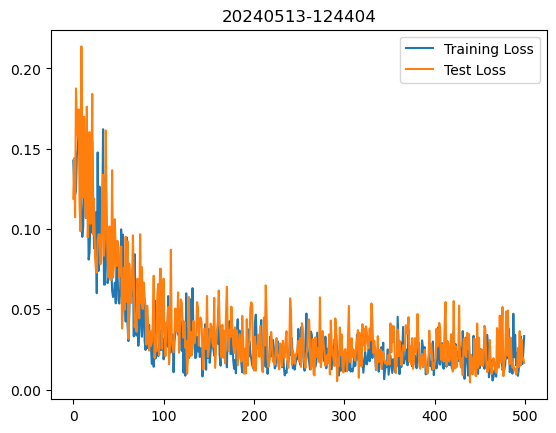

In [82]:
plt.plot(train_loss[:], label='Training Loss')
plt.plot(test_loss[:], label='Test Loss')
plt.legend()
datestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.title(datestring)
# plt.savefig(f'./train_logs/{datestring}.png')

In [83]:
best_loss

0.004441950470209122

In [84]:
model_train(torch.stack([X[0]]).float())*100

tensor([[13.9054, 27.2909, 39.8112]], grad_fn=<MulBackward0>)

In [85]:
torch.save(best_model, f'./models/{datestring}.pth')

In [86]:
datestring

'20240513-124404'

In [87]:
new_model = FinalModel()
new_model.load_state_dict(best_model)

<All keys matched successfully>

In [88]:
array = []
for i in range(len(X_test)):
    X_out = new_model(X_test[i].float())
    # print(X_out)
    Y_out= y_test[i]
    # print(Y_out)
    # array.append((sum((X_out - Y_out)**2)).item())
    array.append(loss_fn(X_out, Y_out).item())
print(sorted(array)[::-1])

[0.237434079992342, 0.23599496394746558, 0.21025824310769473, 0.10415357334732327, 0.09653116390450582, 0.07708445767634452, 0.07017728978279181, 0.07010245229553003, 0.06953080373038527, 0.06316067086075354, 0.05375550992056857, 0.05171871838895692, 0.051068760456003386, 0.04226360206282226, 0.04176877010454255, 0.04106141142526409, 0.03565474190570402, 0.03468160595712287, 0.03436230723884405, 0.0333078108090503, 0.030852344535218863, 0.03027112547436241, 0.029737487088913887, 0.027393330493455298, 0.026649584620306033, 0.025702983373173355, 0.02442277241359687, 0.024380823994859625, 0.021689424088120277, 0.0209430917337206, 0.01931142634501737, 0.018507549668403126, 0.01846772595588934, 0.01793098673927784, 0.017838246055386805, 0.01748455930068207, 0.01717493754513795, 0.01660040749485409, 0.01629469195836292, 0.016050867942646877, 0.016046095947142385, 0.01531941166381387, 0.014203915161763158, 0.013774131364976815, 0.013647437222839648, 0.01257338034842905, 0.012421524219632546, 

In [89]:
np.mean(array)

0.02274333196497543

In [21]:
# array.sort()
# count = 0
# median = np.median(array)
# for i in array:
#     if(i > median):
#         count += 1
# print(count/len(array))